In [45]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import yfinance as yf
import requests

In [46]:
# Black Scholes Option Pricing Model
def black_scholes_prices(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type# . Choose 'call' or 'put'.")

In [47]:
# Greeks calculation
def black_scholes_greeks(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    delta = norm.cdf(d1) if option_type == "call" else -norm.cdf(-d1) 
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T) / 100 # Per 1% change
    return { "delta": delta, "gamma":gamma, "vega": vega}


In [48]:
# 3. Volatillity Surface Stress-Testing
def stress_test_vol_surface(S, K, T, r, base_sigma, stress_range=(0.8, 1.2), steps=20):
    sigmas = np.linspace(base_sigma * stress_range[0], base_sigma * stress_range[1], steps)
    prices_call = [black_scholes_prices(S, K, T, r, sigma, "call") for sigma in sigmas]
    prices_put = [black_scholes_prices(S, K, T, r, sigma, "put") for sigma in sigmas]

    plt.figure(figsize=(12,6))
    plt.plot(sigmas, prices_call, label="Call Price")
    plt.plot(sigmas, prices_put, label="Put Price")
    plt.xlabel('Impied Volatility')
    plt.ylabel('Option Price')
    plt.title('Stress Testing Volatility Assumptions')
    plt.legend()
    plt.grid(True)
    plt.show()

In [49]:
#4. Market Quote Benchmarking

def benchmark_market_quote(model_price, market_price):
    diff = model_price - market_price
    pct_diff = 100 * diff / market_price
    return {"model": model_price, "market": market_price, "difference": diff, "pct_diff": pct_diff}

In [50]:
# 5. Validation Report Generator

def generate_validation_report(S, K, T, r, sigma, market_price, option_type="call"):
    model_price = black_scholes_prices(S, K, T, r, sigma, option_type)
    greeks = black_scholes_greeks(S, K, T, r, sigma, option_type)
    benchmark = benchmark_market_quote(model_price, market_price)

    print("=== Option Validation Report ===")
    print(f"Model Price: {benchmark['model']:.4f}")
    print(f"Market Price: {benchmark['market']:.4f}")
    print(f"Difference: {benchmark['difference']:.4f} ({benchmark['pct_diff']:.2f}%)")
    print("Greeks: ")
    for g, v in greeks.items():
        print(f"   {g}: {v:.4f}")


=== Option Validation Report ===
Model Price: 17.3950
Market Price: 100.0000
Difference: -82.6050 (-82.60%)
Greeks: 
   delta: -0.7128
   gamma: 0.0170
   vega: 0.3407


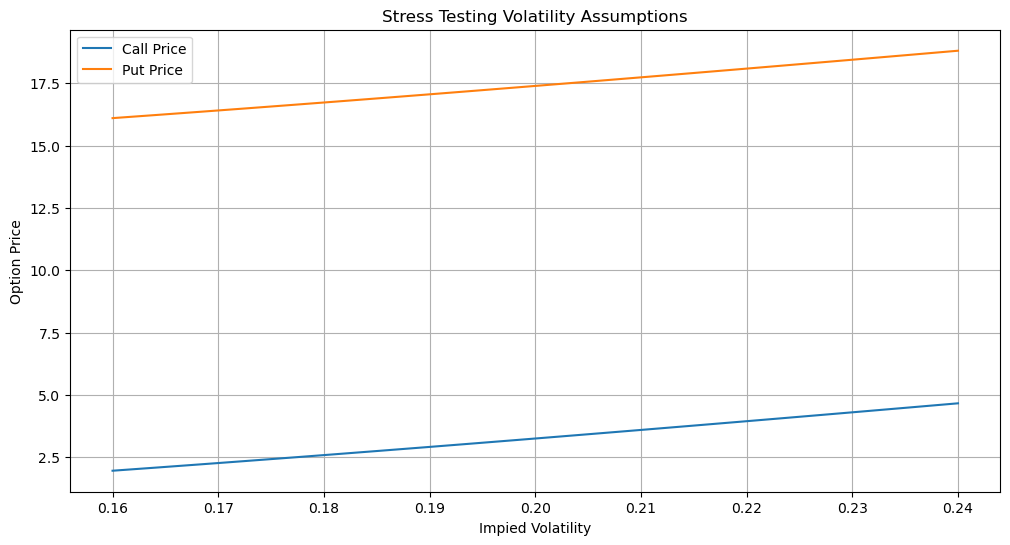

In [51]:
# 6. Example Execution

S, K, T, r, sigma = 100, 120, 1, 0.05, 0.2
market_price = 100

# generate report
generate_validation_report(S, K, T, r, sigma, market_price, "put")

# Stress-Test
stress_test_vol_surface(S, K, T, r, sigma)

In [52]:
def fetch_option_price_yfinance(ticker="AAPl", expiry="2024-12-20", strike=100, option_type="call"):
    try:
        stock = yf.Ticker(ticker)
        chain = stock.option_chain(expiry)
        options_df = chain.calls if option_type == "call" else chain.puts
        match = options_df[options_df["strike"]==strike]
        if match.empty:
            raise ValueError("Strike not found")
        return float(match.iloc[0]["last price"])
    except Exception as e:
        print("YFinance error:", e)
        return None
    


In [61]:
# use environment variables or just hardcode keys
def fetch_option_price_alpaca(ticker="AAPL"):
    API_KEY = "PKOEY8NK7JXD8WBD8J82" 
    SECRET_KEY = "74b9K2VsGyY68yx7w5Ijov5hKdRXoGCFT0h4EjkT"
    BASE_URL = "https://paper-api.alpaca.markets/v2"

    headers = {
        "APCA-API-KEY-ID": API_KEY,
        "APCA-API-SECRET-ID": SECRET_KEY
    }

    url = f"https://data.alpaca.markets/v1beta1/options/contracts/search?underlying_symbol={ticker}"
    try: 
        response = requests.get(url, headers=headers)
        return response.json()
    except Exception as e:
        print("Alpaca error: ", e)
        return None

In [62]:
S, K, T, r, sigma = 100, 100, 1, 0.05, 0.2
raw_price = fetch_option_price_alpaca("AAPL")
market_price = raw_price["last_price"] if raw_price else None
if market_price:
    generate_validation_report(S, K, T, r, sigma, market_price, "call")
    stress_test_vol_surface(S, K, T, r, sigma)
else:
    print("Failed to fetch market price")
 

Alpaca error:  Expecting value: line 1 column 1 (char 0)
Failed to fetch market price


In [63]:
raw_price